In [199]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy

In [200]:
def realignment_coeffs(data):
    """
    对系数进行隔列插零
    """
    z = np.zeros(data.shape[0])
    for i in range(data.shape[1]-1,0,-1):
        data = np.insert(data,i,z,axis=1)
    return data

def realignment_data(data,channel_num):
    disp_len = int(np.ceil(data.size / channel_num))
    patch_size = int(disp_len * channel_num - data.size)
    patch_data = np.concatenate((data, np.zeros(patch_size)))
    polyphase_data = np.zeros(patch_data.size*2) 
    half = (channel_num // 2)
    for i in range(patch_data.size // half):
        if(i == (patch_data.size // half - 1)):
            polyphase_data[i*channel_num+half:(i+1)*channel_num] = patch_data[i*half:(i+1)*half]
        else:
            polyphase_data[i*channel_num+half:(i+1)*channel_num+half] = list(patch_data[i*half:(i+1)*half])*2
    polyphase_data = polyphase_data.reshape( (channel_num, -1), order='F')
    polyphase_data = np.flip(polyphase_data,0)
    return polyphase_data

def gen_filter_coeffs(numtaps, M):
    coeffs = scipy.signal.firwin(numtaps*M, cutoff=2.0/M, window="hamming")
    coeffs = np.reshape(coeffs, (M, -1), order='F')
    coeffs = realignment_coeffs(coeffs)
    return coeffs

def my_coeffs(coeffs, M):
    coeffs = np.reshape(coeffs, (M, -1), order='F')
    coeffs = realignment_coeffs(coeffs)
    return coeffs

def polyphase_filter(data,filter_coeffs,channel_num):   
     
    polyphase_data = realignment_data(data, channel_num)
    polyphase_data = polyphase_data.reshape( (channel_num, -1), order='F')
    
    # print(polyphase_data)
    
    filt_data = np.zeros(polyphase_data.shape)
    for k in range(channel_num):
        filt_data[k] = scipy.signal.lfilter(filter_coeffs[k], 1, polyphase_data[k])
        # filt_data[k] = scipy.signal.rfilter(filter_coeffs[k], 1, filt_data[k])

    dispatch_data = np.fft.fft(filt_data, axis=0)
    return dispatch_data

In [201]:
def apply_chirp(freq,size,bw=400.0,fc=1382.0):
    dm = 2.64476
    dm_dispersion = 2.41e-4
    dispersion_per_MHz = 1e6 * dm / dm_dispersion
    phasors = np.zeros((size),dtype=complex)
    binwidth = -bw / size
    coeff = 2 * np.pi * dispersion_per_MHz / (fc * fc);
    for i in range (size):
        f = i * binwidth + 0.5 * bw
        phasors[i] = np.exp(1j * coeff * f * f / (fc+f));
        if i == 0:
            phasors[i] = 0; 
        freq[i] = phasors[i] * freq[i];

def get_period_size(bw):
    period = 0.00575730363767324
    return int(period * bw * 1e6)

def fold_data(data,blocks,psize):
    cur = 0
    pdata = np.zeros((psize))
    pnum = np.zeros((psize))
    for i in range(blocks):
        if(cur >= psize):
            cur = 0
        pnum[cur] = pnum[cur] + 1
        pdata[cur] = (pnum[cur] - 1) * pdata[cur] / pnum[cur] + data[i] / pnum[cur]
        cur = cur + 1 

In [202]:
def kernel(data,coeffs,nchannels):
       # coeffs = gen_filter_coeffs(ntaps,channel_num)  
    subfreq = polyphase_filter(data,coeffs,nchannels)
    # subfreq = np.flip(subfreq,axis=0)
    b = np.append(subfreq[0],np.flip(subfreq[1:],axis=0))
    subfreq = b.reshape((nchannels,-1))
    freq_size = subfreq.shape[1]
    N = int(freq_size * nchannels // 4)
    myfreq = np.zeros((N), dtype=complex)
    start = 0
    end = 0
    mystart = 0
    myend = 0
    bw = 0
    for i in range(nchannels // 2 + 1):
        mystart += bw
        if i == 0:
            start = freq_size // 2
            end = freq_size // 2 + freq_size // 4
        elif i == nchannels // 2:
            start = freq_size // 2 - freq_size // 4
            end = freq_size // 2 
        else:
            start = freq_size // 2 - freq_size // 4
            end = freq_size // 2 + freq_size // 4
        bw = end - start
        myend = mystart + bw
        
        if i % 2 == 0:
            myfreq[mystart:myend] = scipy.fft.fftshift(scipy.fft.fft(subfreq[i]))[start:end]
        else:
            myfreq[mystart:myend] = scipy.fft.fft(subfreq[i])[start:end]
    # opfb_t = np.abs(scipy.fft.fft(myfreq))
    
    return myfreq,subfreq

In [203]:
def integral_data(data,size,n=1024):
    data = np.abs(data)
    bins = size // n
    out = np.zeros((1024))
    sum = 0
    index = 0
    i = 0
    while(1):
        sum = 0
        j = 0
        while(1):
            if j > bins or i > (bins * (n-1)):
                break
            sum += data[i]
            i += 1
            j += 1
        out[index] = sum / j
        index += 1
        # print(i)
        if i > (bins * (n-1)):
            break
    sum = 0
    while(1):
        if i >= size:
            break
        sum += data[i]
        i += 1
    
    out[n-1] = sum / (size - n * bins + bins);
    return out

In [204]:
coeffs = np.loadtxt("coeffs.txt")
data = np.loadtxt("time_24.txt")
ocoeffs = my_coeffs(coeffs,16)
fullfreq,myfreq = kernel(data,ocoeffs,16)

In [205]:
ifull = integral_data(fullfreq,fullfreq.shape[0])

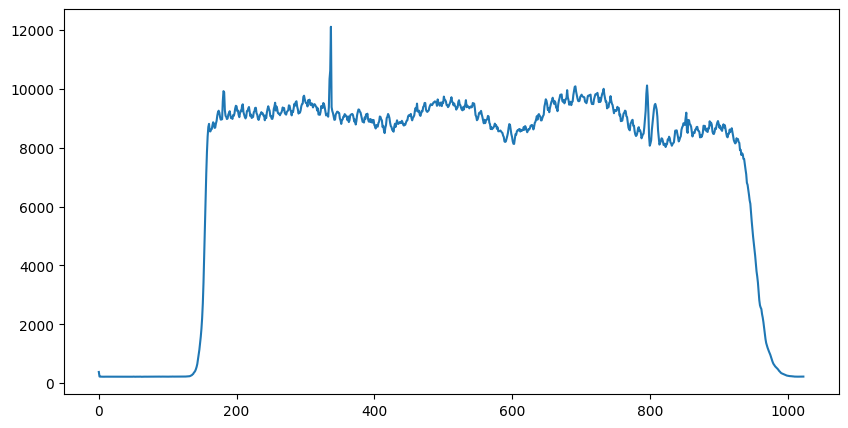

In [206]:
plt.figure(figsize=(10,5))
plt.plot(ifull)

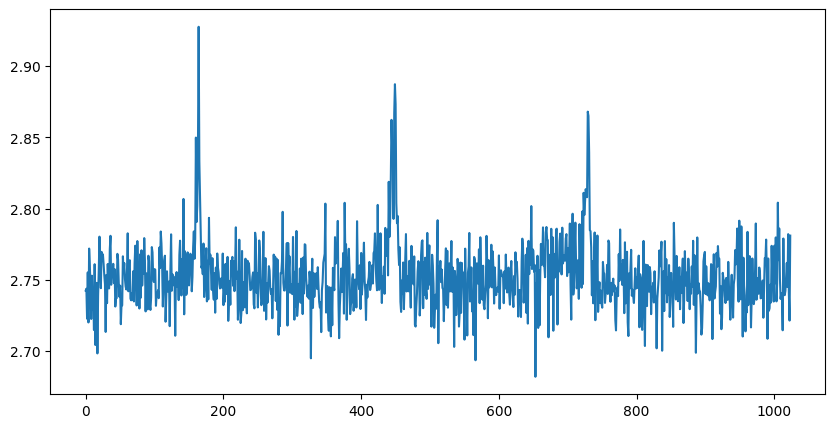

In [207]:
psize = get_period_size(400.0)
apply_chirp(fullfreq,fullfreq.shape[0])
tfull = np.fft.ifft(fullfreq)
idata = integral_data(tfull,tfull.shape[0])
plt.figure(figsize=(10,5))
plt.plot(idata)